In [288]:
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from IPython.display import display

# Data ingestion

In [289]:
url = 'https://nyc-tlc.s3.amazonaws.com/trip+data/'
files = ['fhv_tripdata_2021-01.parquet', 'fhv_tripdata_2021-02.parquet']
data_sources = [url + file for file in files]
data_destinations = ['./data/' + file for file in files]

In [290]:
for i in range(len(data_sources)):
    source = data_sources[i]
    destination = data_destinations[i]
    print(f'Downloading {data_sources[i]}')
    !curl $source -o $destination --create-dirs 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  2 11.3M    2  237k    0     0   265k      0  0:00:43 --:--:--  0:00:43  265k
 12 11.3M   12 1495k    0     0   814k      0  0:00:14  0:00:01  0:00:13  815k
 26 11.3M   26 3025k    0     0  1057k      0  0:00:10  0:00:02  0:00:08 1057k
 40 11.3M   40 4674k    0     0  1211k      0  0:00:09  0:00:03  0:00:06 1211k
 53 11.3M   53 6221k    0     0  1286k      0  0:00:09  0:00:04  0:00:05 1286k
 68 11.3M   68 7904k    0     0  1348k      0  0:00:08  0:00:05  0:00:03 1543k
 83 11.3M   83 9655k    0     0  1408k      0  0:00:08  0:00:06  0:00:02 1626k
 98 11.3M   98 11.1M    0     0  1460k      0  0:00:07  0:00:07 --:--:-- 1691k
100 11.3M  100 11.3M    0     0  1464k      0  0:00:07  0:00:07 --:--:-- 1705k
  % Total    % Received % Xferd  Average Speed   Ti

# Data preparation
- Look at the data
- Make column names and values look uniform
- Check if all the columns read correctly
- Check and transform types - categorical/numerical features

In [346]:
def read_dataframe (data_file, categorical_features=None, numerical_features=None, target=None, verbose=False):
    
    if (verbose): print(f'Processing dataset {data_file}')
    df = pd.read_parquet(data_file)
    if (verbose): print(f'shape: {df.shape}')
    df.columns.str.lower().str.replace(' ','_')
    if (verbose): print(f'types:\n{df.dtypes}')
    
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    numerical_columns = list(df.dtypes[df.dtypes != 'object'].index)
    
    for column in categorical_columns:
        # This will not touch the None values, only the not None types are processed (type(df['store_and_fwd_flag'].iloc[-1]) => 'NoneType')
        df[column] = df[column].str.lower().str.replace(' ', '_')

    df['duration'] = (df['dropOff_datetime'] - df['pickup_datetime']).dt.seconds / 60

    if verbose:
        display(df.head().T)
        print(f'types:\n{df.dtypes}')
        
        print('\nUniques values\n')
        
        for c in df.columns:
            print(c)
            nuniques = df[c].nunique()
            if nuniques < 20:
                display(c, df[c].unique())
            else:
                print(f'Number of uniques values is {nuniques}')
            
        print('\ncategorical_columns\n')
        for column in categorical_columns:
            display(f'Feature: {column}')
            nuniques = df[column].nunique()
            display(f'Number of unique values: {nuniques}')
            display(f'Number of nulls: {df[column].isnull().sum()}')
            if nuniques < 20:
                display(df[column].value_counts(normalize=True))
            
        print('\nnumerical_columns\n')
        for column in numerical_columns:
            display(f'Feature: {column}')
            nuniques = df[column].nunique()
            display(f'Number of unique values: {nuniques}')
            display(f'Number of nulls: {df[column].isnull().sum()}')
            if nuniques < 20:
                display(df[column].value_counts(normalize=False))
        
        sns.displot(df.duration, kind='kde')
        print('\ndescription of duration:')
        print(df['duration'].describe(percentiles=[0.1, 0.2, 0.95, 0.98, 0.99]))
        print(f'% of trips within 1-60 min: {((df.duration >= 1) & (df.duration<=60)).mean()}')
    
    if (verbose): print('\nFiltering by duration...')
    df = df[(df.duration >= 1) & (df.duration<=60)]
    if (verbose): print(f'shape: {df.shape}')

    for column in ['PUlocationID', 'DOlocationID']:
        if (verbose): print(f'\nFilling {round(df[column].isna().mean()*100,2)}% of nans with -1 in column: {column}')
        df[column].fillna(-1, inplace=True)
        
    if not categorical_features:
        categorical_features = ['PUlocationID', 'DOlocationID']
    if not numerical_features:
        numerical_features =  []
    if not target:
        target = ['duration']
    df[categorical_features] = df[categorical_features].astype('str')
    df.drop(df.columns.difference(categorical_features+numerical_features+target), axis=1, inplace=True)    
    
    if verbose:
        print(f'\nfinal shape: {df.shape}')
        print(f'\nfinal types:\n{df.dtypes}')
        print(f'\ncategorical_features: {categorical_features}')
        print(f'\nnumerical_features: {numerical_features}')
        print(f'\ntarget: {target}')       
    
    return df[categorical_features+numerical_features],df[target] 
    

# Data Reading and preparation from function

In [347]:
categorical_features = ['PUlocationID', 'DOlocationID']
numerical_features=  []
target = ['duration']

Processing dataset https://nyc-tlc.s3.amazonaws.com/trip+data/fhv_tripdata_2021-01.parquet
shape: (1154112, 7)
types:
dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
dtype: object


,0,1,2,3,4
dispatching_base_num,b00009,b00009,b00013,b00037,b00037
pickup_datetime,2021-01-01 00:27:00,2021-01-01 00:50:00,2021-01-01 00:01:00,2021-01-01 00:13:09,2021-01-01 00:38:31
dropOff_datetime,2021-01-01 00:44:00,2021-01-01 01:07:00,2021-01-01 01:51:00,2021-01-01 00:21:26,2021-01-01 00:53:44
PUlocationID,NaN,NaN,NaN,NaN,NaN
DOlocationID,NaN,NaN,NaN,72.0,61.0
SR_Flag,None,None,None,None,None
Affiliated_base_number,b00009,b00009,b00013,b00037,b00037
duration,17.0,17.0,110.0,8.283333,15.216667


types:
dispatching_base_num              object
pickup_datetime           datetime64[ns]
dropOff_datetime          datetime64[ns]
PUlocationID                     float64
DOlocationID                     float64
SR_Flag                           object
Affiliated_base_number            object
duration                         float64
dtype: object

Uniques values

dispatching_base_num
Number of uniques values is 537
pickup_datetime
Number of uniques values is 807066
dropOff_datetime
Number of uniques values is 812640
PUlocationID
Number of uniques values is 261
DOlocationID
Number of uniques values is 262
SR_Flag


'SR_Flag'

array([None], dtype=object)

Affiliated_base_number
Number of uniques values is 699
duration
Number of uniques values is 10790

categorical_columns



'Feature: dispatching_base_num'

'Number of unique values: 537'

'Number of nulls: 0'

'Feature: SR_Flag'

'Number of unique values: 0'

'Number of nulls: 1154112'

Series([], Name: SR_Flag, dtype: float64)

'Feature: Affiliated_base_number'

'Number of unique values: 699'

'Number of nulls: 885'


numerical_columns



'Feature: pickup_datetime'

'Number of unique values: 807066'

'Number of nulls: 0'

'Feature: dropOff_datetime'

'Number of unique values: 812640'

'Number of nulls: 0'

'Feature: PUlocationID'

'Number of unique values: 261'

'Number of nulls: 958267'

'Feature: DOlocationID'

'Number of unique values: 262'

'Number of nulls: 162220'


description of duration:
count    1.154112e+06
mean     1.861074e+01
std      2.736175e+01
min      0.000000e+00
10%      4.333333e+00
20%      6.633333e+00
50%      1.340000e+01
95%      4.725000e+01
98%      6.610000e+01
99%      9.016667e+01
max      1.430000e+03
Name: duration, dtype: float64
% of trips within 1-60 min: 0.9616510356013974

Filtering by duration...
shape: (1109853, 8)

Filling 83.53% of nans with -1 in column: PUlocationID

Filling 13.33% of nans with -1 in column: DOlocationID

final shape: (1109853, 3)

final types:
PUlocationID     object
DOlocationID     object
duration        float64
dtype: object

categorical_features: ['PUlocationID', 'DOlocationID']

numerical_features: []

target: ['duration']


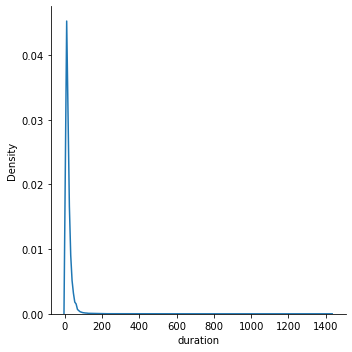

In [348]:
df_train, y_train = read_dataframe(data_sources[0], categorical_features=categorical_features, numerical_features=numerical_features, target=target, verbose=True)
df_val, y_val = read_dataframe(data_sources[1], categorical_features=categorical_features, numerical_features=numerical_features, target=target)

# Encoding

In [349]:
dv = DictVectorizer()

In [350]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')

In [351]:
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [352]:
print(f'Number of caterories in df_train: {dv.get_feature_names_out().shape}')

Number of caterories in df_train: (525,)


In [353]:
y_train = y_train[target].values
y_val = y_val[target].values

# Lineal regression

In [354]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [355]:
y_pred = lr.predict(X_train)

C:\Users\MARCOS\anaconda3\envs\mlops-zoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\MARCOS\anaconda3\envs\mlops-zoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


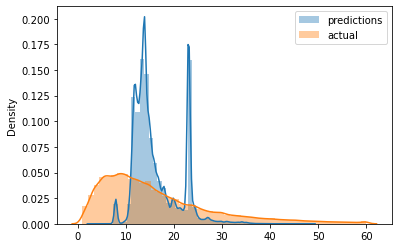

In [356]:
sns.distplot(y_pred, label='predictions')
sns.distplot(y_train, label='actual')
plt.legend()

Check performance in training dataset with rmse (return rmse, so is interpreted as the mean error in minutes)

In [357]:
mean_squared_error(y_train,y_pred, squared=False)

10.528643263699815

The performance of this baseline model is bad. We can use other features, or change the 

# Validation framework
We will use datasets from different months for train and validation

In [363]:
y_pred = lr.predict(X_val)

In [364]:
mean_squared_error(y_val,y_pred, squared=False)

11.0145436775827

# Other models

In [365]:
lr = Lasso(alpha=0.01)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

11.303383133969728

In [366]:
lr = Ridge()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

11.0145436775827

# Feature engineering
Combine PU and DO (interaction features)

In [367]:
df_train['PU_DO'] = df_train['PUlocationID'] + '_' + df_train['DOlocationID']
df_val['PU_DO'] = df_val['PUlocationID'] + '_' + df_val['DOlocationID']

In [370]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = []

In [371]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [372]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

10.596653391725953

Save the best result

In [373]:
import os
if not os.path.exists("./models"):
    os.makedirs("./models")

with open('models/lin_reg_green.bin','bw') as f_out:
    pickle.dump((dv,lr), f_out)

In [ ]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)